<a href="https://colab.research.google.com/github/danielx1611/ComputerVisionAssignments/blob/main/AugmentedRealityPyTorch3D/AugmentedRealityPyTorch3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Augmented Reality with PyTorch3D

## PyTorch3D Initialization

In [ ]:
def gh_clone(user, repo):
    url = f"https://github.com/{user}/{repo}.git"
    !git clone $url
    !git remote set-url origin $url

gh_clone("ribeiro-computer-vision", "pytorch3d_rendering")

# ✅ Verify that the repository was cloned
import os
repo_name = "/content/pytorch3d_rendering"   # <-- change to your repository folder name
if os.path.exists(repo_name):
    print(f"✅ Repository '{repo_name}' successfully cloned!")
else:
    print(f"❌ Repository '{repo_name}' not found. Try cloning manually.")

import sys
sys.path.append('/content/pytorch3d_rendering')

CONTENT_DIR = Path(".")

try:
    import google.colab.patches as patches
    print("in collab")
    cv2_imshow = patches.cv2_imshow
    CONTENT_DIR = Path("/content")

    if not Path("ComputerVisionAssignments").exists():
      !git clone https://github.com/danielx1611/ComputerVisionAssignments

    # Move test files to the Colab local directory (i.e., /content/)
    if not Path("images").exists():
      !mkdir images
    !cp -r ComputerVisionAssignments/PinholeCameraModel/chess_jpg/* ./images
except:
    pass


fatal: destination path 'pytorch3d_rendering' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
✅ Repository '/content/pytorch3d_rendering' successfully cloned!
in collab
Cloning into 'ComputerVisionAssignments'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 148 (delta 17), reused 21 (delta 6), pack-reused 78 (from 2)
Receiving objects: 100% (148/148), 59.01 MiB | 49.29 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
# --- Config ---
mount_gdrive = False

# --- Imports (module you saved as sse_env.py) ---
import importlib, os, sys, shutil, subprocess, urllib.request, pathlib
import installation_tools as install_tools
importlib.reload(install_tools)

# --- Short helpers (no notebook magics) ---
def run(cmd, check=True):
    print("$", " ".join(cmd))
    try:
        subprocess.run(cmd, check=check)
    except subprocess.CalledProcessError as e:
        print(f"Command failed ({e.returncode}): {' '.join(cmd)}")
        if check:
            raise

def pip_install(*pkgs, extra=None, check=True):
    args = [sys.executable, "-m", "pip", "install"]
    if extra:
        args += extra
    args += list(pkgs)
    run(args, check=check)

def conda_available():
    return shutil.which("conda") is not None

def conda_install(*pkgs):
    if not conda_available():
        print("conda not available; skipping conda installs.")
        return
    # Use -c conda-forge channel and auto-yes
    run(["conda", "install", "-y", "-c", "conda-forge", *pkgs], check=False)

# --- Detect platform ---
pm = install_tools.PlatformManager()
platform, local_path = pm.platform, pm.local_path
print("Detected:", platform, local_path)

# --- Optional: Mount GDrive if on Colab ---
if mount_gdrive and platform == "Colab":
    pm.mount_gdrive()

# --- Lightning AI specific environment tweaks ---
if platform == "LightningAI":
    # conda piece (if conda exists in the image)
    conda_install("libstdcxx-ng=13")
    # pip pins / extras
    pip_install("numpy<2.0", check=False)
    pip_install("scikit-image", "gradio", "moviepy", "plotly", check=False)
    # If requirements.txt exists in CWD, install it
    if os.path.exists("requirements.txt"):
        pip_install("-r", "requirements.txt")

# --- Install PyTorch3D (handles platform differences & fallbacks) ---
installer = install_tools.PyTorch3DInstaller(platform, local_path)
installer.install()

# --- Extra libraries (quiet-ish) ---
# Original line had: trimesh pyrender opencv-python matplotlib pytorch-lightning
pip_install("trimesh", "pyrender", "opencv-python", "matplotlib", "pytorch-lightning", check=False)

# --- Download plot_image_grid.py if missing ---
filename = "plot_image_grid.py"
url = "https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py"
if not os.path.exists(filename):
    print(f"Downloading {filename} ...")
    try:
        urllib.request.urlretrieve(url, filename)
        print("Saved to", pathlib.Path(filename).resolve())
    except Exception as e:
        print("Download failed:", e)

# --- gdown ---
pip_install("gdown", extra=["--quiet"], check=False)
print("✅ Setup complete.")

Running on Colab.
Detected: Colab /content/
$ /usr/bin/python3 -m pip install --upgrade pip
$ /usr/bin/python3 -m pip install --upgrade pip
$ sudo apt-get -qq update
$ sudo apt-get install -y freeglut3-dev libglew-dev libsdl2-dev
$ /usr/bin/python3 -m pip install PyOpenGL PyOpenGL_accelerate

PyTorch3D target wheel tag: py312_cu126_pyt280

$ /usr/bin/python3 -m pip install iopath
Trying to install PyTorch3D wheel on Colab (Linux).
$ /usr/bin/python3 -m pip install https://www.dropbox.com/scl/fi/fqvlnyponcbekjd01omhj/pytorch3d-0.7.8-cp312-cp312-linux_x86_64.whl?rlkey=563mfx35rog42z1c8y7qn31sk&dl=1
✅ PyTorch3D successfully installed!
$ /usr/bin/python3 -m pip install trimesh pyrender opencv-python matplotlib pytorch-lightning
Saved to /content/plot_image_grid.py
$ /usr/bin/python3 -m pip install --quiet gdown
✅ Setup complete.


## Imports

In [ ]:
# ---------------------------- IMPORTS -----------------------------------------
# Stdlib
import os
import sys
import math
import shutil
from pathlib import Path
from typing import Optional, Tuple, Literal, Dict, Any

# Third-party
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import imageio
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm.notebook import tqdm
from skimage import img_as_ubyte

# PyTorch3D — IO & data structures
from pytorch3d.io import load_obj, load_ply, load_objs_as_meshes
from pytorch3d.structures import Meshes

# PyTorch3D — transforms
from pytorch3d.transforms import Rotate, Translate

# PyTorch3D — rendering
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PerspectiveCameras,
    look_at_view_transform,
    look_at_rotation,
    camera_position_from_spherical_angles,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    BlendParams,
    SoftSilhouetteShader,
    SoftPhongShader,
    HardPhongShader,
    PointLights,
    DirectionalLights,
    Materials,
    TexturesUV,
    TexturesVertex,
)
from pytorch3d.renderer.cameras import CamerasBase

# PyTorch3D — visualization helpers (optional)
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

# Project utils path (adjust as needed)
sys.path.append(os.path.abspath(''))
# ------------------------------------------------------------------------------

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2025-10-02 15:45:34--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.1’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-10-02 15:45:34 (32.7 MB/s) - ‘plot_image_grid.py.1’ saved [1608/1608]



In [ ]:

# ---------- pretty print helpers ----------
RESET="\033[0m"; BOLD="\033[1m"
C={"ok":"\033[1;32m","info":"\033[1;36m","step":"\033[1;35m","warn":"\033[1;33m"}
CYAN  = "\033[1;36m"; GREEN = "\033[1;32m"; YELLOW = "\033[1;33m"


def say(kind,msg): print(f"{C[kind]}{msg}{RESET}")
torch.set_printoptions(precision=4, sci_mode=False)
np.set_printoptions(precision=4, suppress=True)

## Download cow object mesh and convert it to PyTorch3D mesh

In [ ]:

import tools_pytorch3d_coordsystems_demo as myp3dtools
import tools_image_processing as myimgtools
myp3dtools.download_cow_mesh()


Creating data/cow_mesh directory...
Saved → data/cow_mesh/cow.obj
Saved → data/cow_mesh/cow.mtl
Saved → data/cow_mesh/cow_texture.png
Cow mesh download complete!


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print("Device:", device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)



Device: cuda:0


## PyTorch3D Specific Imports

In [ ]:

import torch
from pytorch3d.renderer import PerspectiveCameras
from pytorch3d.utils import opencv_from_cameras_projection, cameras_from_opencv_projection

# --- PyTorch3D + OpenCV: render the same pose using an EXISTING mesh ----------
# Requirements: `mesh` is a PyTorch3D Meshes with a single item (batch=1).
# If it has no textures, a flat vertex color is applied for PyTorch3D shading.

import numpy as np
import torch, cv2
import matplotlib.pyplot as plt

from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, SoftPhongShader, RasterizationSettings,
    PointLights, PerspectiveCameras, Materials
)
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex


## Calibration

In [ ]:

import cv2 as cv
import json

CONTENT_DIR = Path("/content")
image_dir = CONTENT_DIR / "images"
output_dir = CONTENT_DIR / "output"
output_dir.mkdir(exist_ok=True)
images = list(image_dir.glob("*.jpeg")) + list(image_dir.glob("*.jpg"))


class Calibration:
    @staticmethod
    def run():
        # termination criteria
        criteria = (
            cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,
            30,
            0.001,
        )  # 30: max_iter , 0.001 : accuracy

        # prepare object points, like (0,0,0), (1,0,0), ..., (6,5,0)
        objp = np.zeros((9 * 6, 3), np.float32)  #
        objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(
            -1, 2
        )  # reshaped to [42,2] only take X and Y


        calibration_data = {}

        CHECKERBOARD_SIZE = (9, 6)

        for fname in images:
            # Arrays to store object points and image points from all the images.
            objpoints: list[cv.typing.MatLike] = []  # 3d point in real world space [X,Y,Z]
            imgpoints: list[cv.typing.MatLike] = []  # 2d points in image plane. [X,Y]

            print(fname)
            img = cv.imread(str(fname))

            if img is None:
                print("Invalid image")
                continue

            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

            # Find the chess board corners
            ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD_SIZE, None)

            # If found, add object points, image points (after refining them)
            if ret == True:
                objpoints.append(objp)

                corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
                imgpoints.append(corners2)

                # Draw and display the corners
                cv.drawChessboardCorners(img, CHECKERBOARD_SIZE, corners2, ret)
                # cv.imshow("img", img)
                # cv.waitKey(500)

                cv.imwrite(str(CONTENT_DIR / "output" / (fname.name + "_corners.png")), img)

                # Calibration Part
                ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)  # type: ignore

                img = cv.imread(str(fname))

                if img is None:
                    continue

                h, w = img.shape[:2]

                # Save results into calibration.json
                calibration_data[str(fname)] = (
                    {
                        "K": mtx.tolist(),  # Intrinsic matrix
                        "D": dist.tolist(),  # Distortion coefficients
                        "R": [
                            cv.Rodrigues(r)[0].tolist() for r in rvecs
                        ],  # Convert rvec to rotation matrix
                        "t": [t.tolist() for t in tvecs],  # Translation vectors
                        "width": w,
                        "height": h,
                    }
                )

                mean_error = 0
                for i in range(len(objpoints)):
                    imgpoints2, _ = cv.projectPoints(
                        objpoints[i], rvecs[i], tvecs[i], mtx, dist
                    )
                    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
                    mean_error += error

                print("total error: {}".format(mean_error / len(objpoints)))

        with open("calibration.json", "w") as f:
            json.dump(calibration_data, f, indent=2)

        return "Calibration successful"

Calibration.run()

/content/images/IMG_6723.jpg
total error: 0.029469821099618057
/content/images/IMG_6734.jpg
total error: 0.027878106946686354
/content/images/IMG_6726.jpg
total error: 0.024397112243425285
/content/images/IMG_6719.jpg
total error: 0.02888636585589457
/content/images/IMG_6730.jpg
total error: 0.02757018184159117
/content/images/IMG_6704.jpg
total error: 0.02591630111925812
/content/images/IMG_6728.jpg
total error: 0.02228891050019366
/content/images/IMG_6722.jpg
total error: 0.02652852587837522
/content/images/IMG_6720.jpg
total error: 0.029237056882411912
/content/images/IMG_6732.jpg
total error: 0.02473621818537208
/content/images/IMG_6706.jpg
total error: 0.02438504256457315
/content/images/IMG_6716.jpg
total error: 0.5111775566145916
/content/images/IMG_6715.jpg
total error: 0.02559616109420546
/content/images/IMG_6717.jpg
total error: 0.029422015166252154
/content/images/IMG_6705.jpg
total error: 0.026549450994940303
/content/images/IMG_6710.jpg
total error: 0.02769998726026164
/co

'Calibration successful'

## Generate PyTorch3D Renders

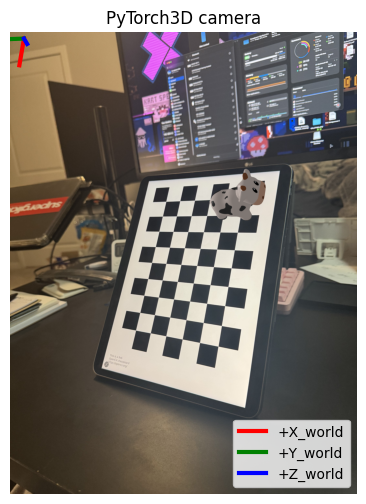

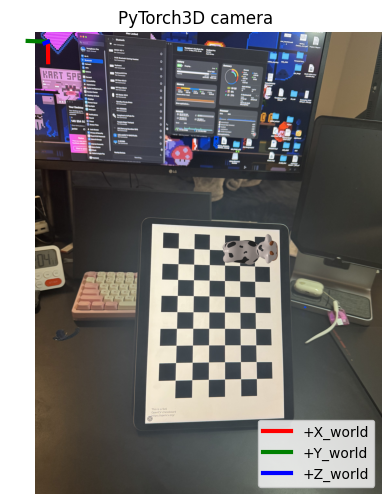

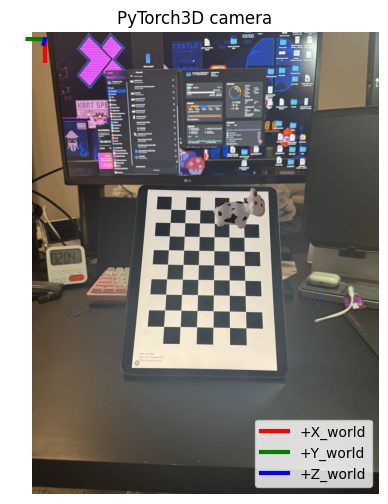

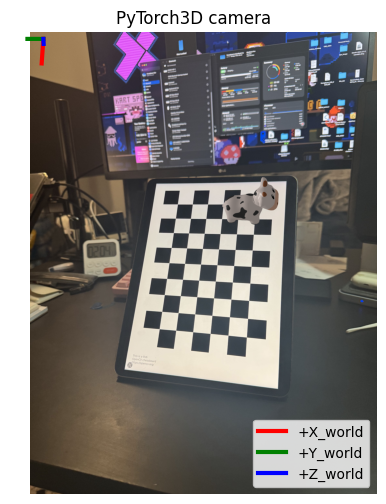

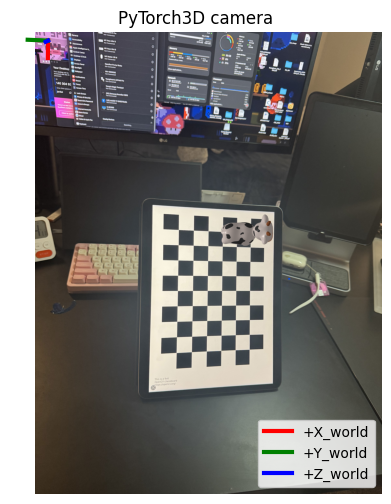

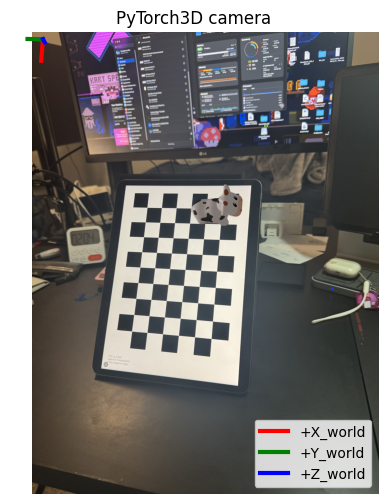

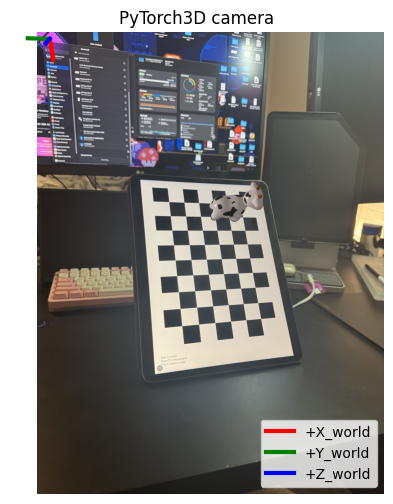

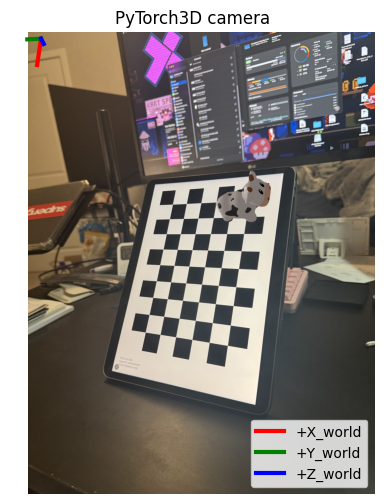

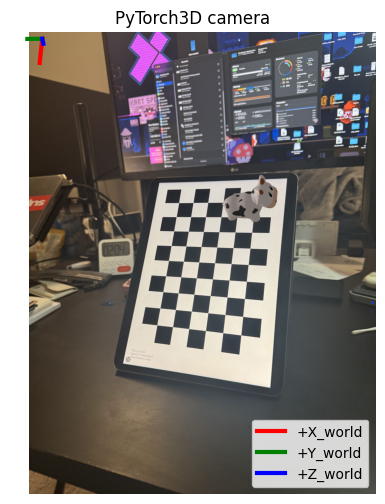

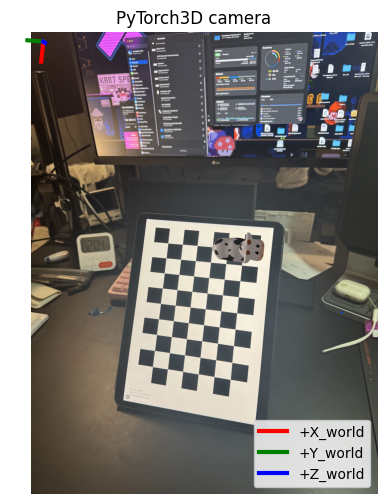

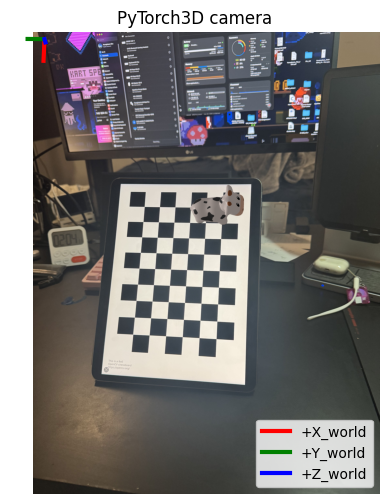

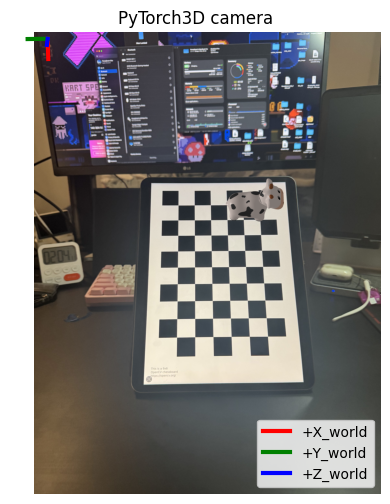

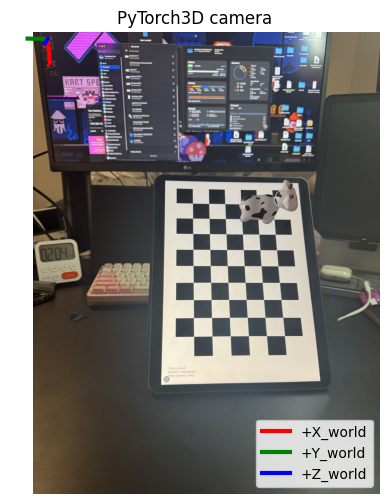

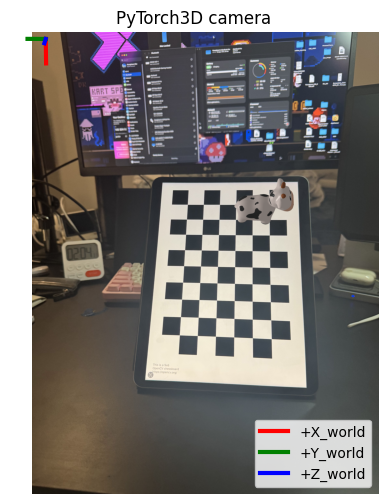

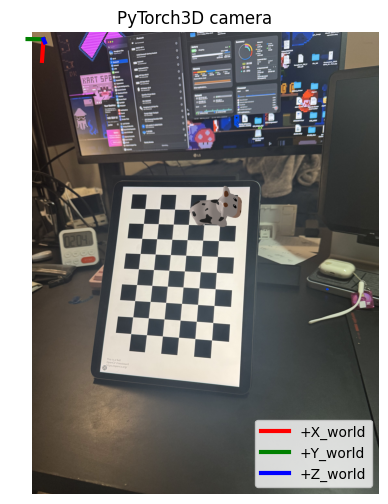

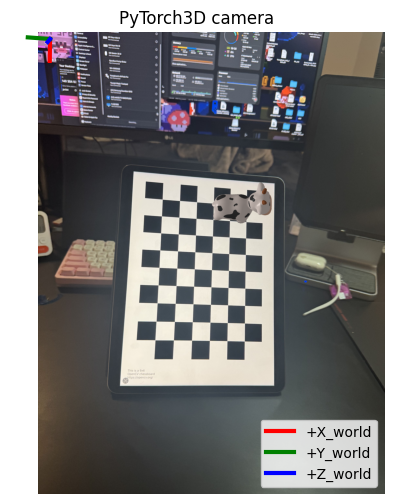

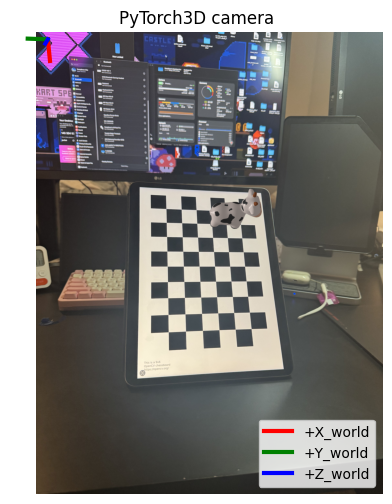

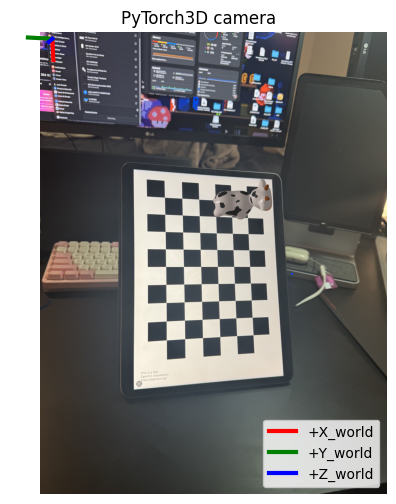

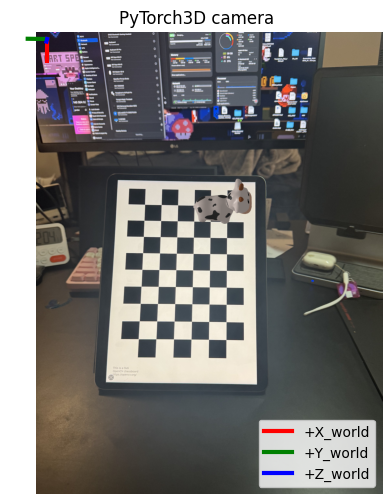

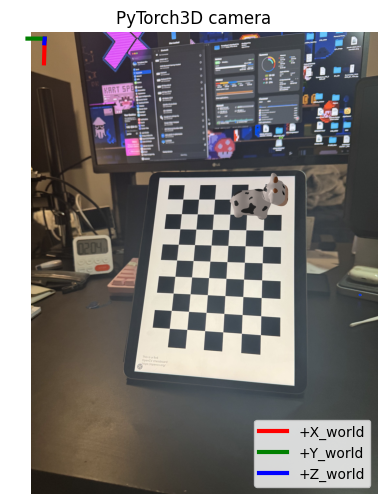

In [ ]:
import cv2
import torch
import numpy as np
from pytorch3d.transforms import RotateAxisAngle

rot = RotateAxisAngle(angle=180.0, axis="X", device=device)
mesh = mesh.clone().update_padded(rot.transform_points(mesh.verts_padded()))
# -----------------------------
# 1️⃣ Checkerboard parameters
# -----------------------------
CHECKERBOARD = (9, 6)  # inner corners (width, height)
square_size = 0.025    # meters

# Prepare object points (0,0,0), (1,0,0), ... scaled by square_size
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= square_size

# -----------------------------
# 2️⃣ Load image and find corners
# -----------------------------

calibration_data = json.load(open("calibration.json", "r"))

for img in calibration_data:
  data = calibration_data[img]
  img = cv2.imread(img)

  K = np.array(data["K"], dtype=np.float32)
  dist = np.array(data["D"])

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
  if not ret:
      raise RuntimeError("Checkerboard not found!")

  # Refine corner positions
  criteria = (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 30, 0.001)
  corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)

  # 4️⃣ SolvePnP: object -> camera
  # -----------------------------
  success, rvec, tvec = cv2.solvePnP(objp, corners2, K, dist)
  if not success:
      raise RuntimeError("solvePnP failed")

  # Convert rotation vector to rotation matrix
  R_cv, _ = cv2.Rodrigues(rvec)

  # -----------------------------
  # 5️⃣ Convert to PyTorch3D convention (world -> camera)
  # -----------------------------
  R_pt3d = torch.from_numpy(R_cv).float().to(device)               # transpose
  T_pt3d = torch.from_numpy((tvec).squeeze()).float().to(device)      # -R^T * tvec

  # Image size (height, width)
  image_size = torch.tensor([[gray.shape[0], gray.shape[1]]], dtype=torch.int32)

  # -----------------------------
  # 6️⃣ Create PyTorch3D camera
  # -----------------------------
  from pytorch3d.utils import cameras_from_opencv_projection

  cameras = cameras_from_opencv_projection(R_pt3d.unsqueeze(0),
                                          T_pt3d.unsqueeze(0),
                                          torch.from_numpy(K).unsqueeze(0).to(device),
                                          image_size.to(device))


  # Example setup (you already have cameras)
  raster_settings = RasterizationSettings(
      image_size=(gray.shape[0], gray.shape[1]), # match background image size
      blur_radius=0.0,
      faces_per_pixel=1,
  )

  # Simple white light
  lights = None  # defaults to a point light above the camera

  renderer = MeshRenderer(
      rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
      shader=SoftPhongShader(cameras=cameras, lights=lights, device=device)
  )

  # Render images
  images = renderer(mesh.scale_verts(0.05).to(device))
  rendered = images[0, ..., :3].cpu().numpy()

  background = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # float32 0..1
  rendered = np.clip(rendered, 0, 1)
  mask = (images[0, ..., 3] > 0).cpu().numpy()
  # Convert to float in [0,1]
  background = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

  composite = background.copy()
  composite[mask] = rendered[mask]

  # ------------------------------- Show results ---------------------------------
  myp3dtools.overlay_axes_p3d(composite, cameras, 256, 256,
                  world_origin=(0,0,0), axis_len=0.5,
                  draw_world_axes=True, draw_camera_axes=False,
                  cam_axis_len=0.5,
                  title="PyTorch3D camera")